In [1]:
import numpy as np
import pandas as pd
import mph
from statistics import mean, stdev, mode

import pyro
import pyro.distributions as dist
import pyro.poutine as poutine
from pyro.infer import SVI, Trace_ELBO, TraceMeanField_ELBO,TraceGraph_ELBO, MCMC, NUTS, HMC
from pyro.poutine.runtime import effectful

import torch
from torch.distributions import constraints

import matplotlib.pyplot as plt
import seaborn as sns
import time 

from scipy import stats
import graphviz
from tqdm import tqdm

import yaml



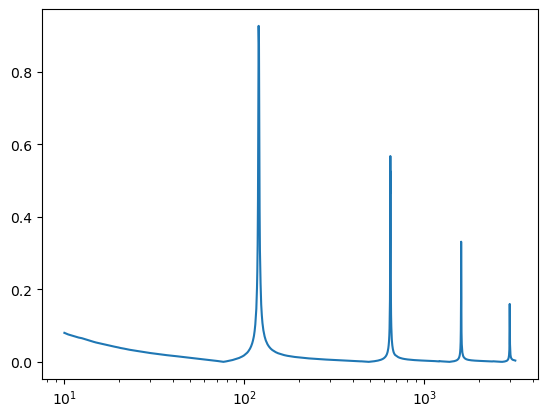

In [2]:
experiment = pd.read_csv("../Data/bend/centerFreqResponse.csv")[20:]
# Mobility value calculated from input data and converted to torch
mobility = abs(experiment["force"].values + 1j*experiment["velocity"].values)
freq = experiment["freq"].values
plt.plot(freq, mobility)
#plt.xlim([50, 200])
plt.xscale("log")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


0.2248792458969416
0.1621429335227826


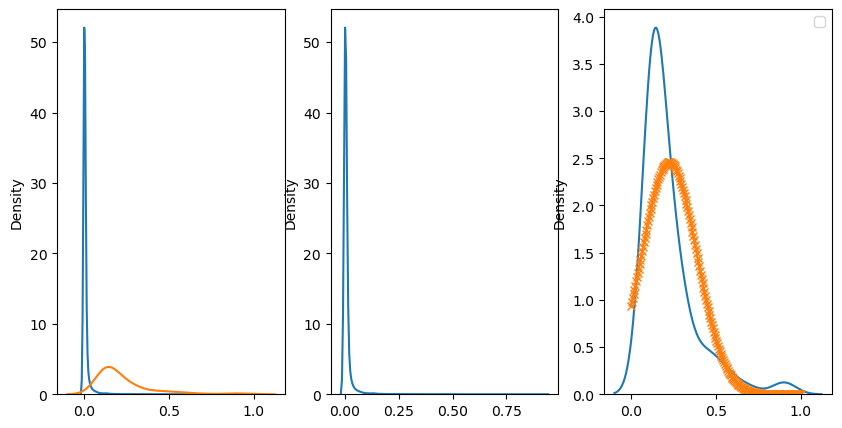

In [3]:
fig, axes = plt.subplots(figsize=(10,5), ncols=3, nrows=1)
#goal = mobility[np.logical_and(mobility>0.2, mobility<0.75)]
goal = mobility[mobility>0.1]
#goalFreq = freq[np.logical_and(mobility>0.2, mobility<0.75)]
goalFreq = freq[mobility>0.1]
sns.kdeplot(mobility, label="mobility all values", ax=axes[0])
sns.kdeplot(goal, label="mobility > 0.2", ax=axes[0])
sns.kdeplot(mobility, ax=axes[1])
meanDist = mean(goal)
stdDist = stdev(goal)
print(meanDist)
print(stdDist)
x = np.linspace(0, 1, 200)
sns.kdeplot(goal, ax=axes[2])
axes[2].plot(x, stats.norm.pdf(x, meanDist, stdDist), "x-")
plt.legend()

In [4]:
stats.beta.fit(goal)

/opt/miniconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:684: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)


(0.5989102454863557,
 1.4786801028827505,
 0.2003440295683652,
 0.5116303893151558)

Text(1000, 0.65, 'number of points: 90')

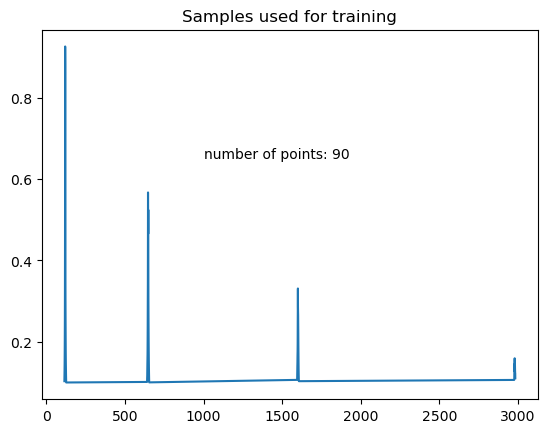

In [6]:
plt.plot(goalFreq, goal)
plt.title("Samples used for training")
plt.text(1000, 0.65,"number of points: "+str(len(goal)))

In [5]:
goalFreq

array([ 115. ,  115.5,  116. ,  116.5,  117. ,  117.5,  118. ,  118.5,
        119. ,  119.5,  120. ,  120.5,  121. ,  121.5,  122. ,  122.5,
        123. ,  123.5,  124. ,  124.5,  125. ,  125.5,  126. ,  126.5,
        641. ,  641.5,  642. ,  642.5,  643. ,  643.5,  644. ,  644.5,
        645. ,  645.5,  646. ,  646.5,  647. ,  647.5,  648. ,  648.5,
        649. ,  649.5,  650. ,  650.5,  651. ,  651.5,  652. ,  652.5,
        653. ,  653.5,  654. ,  654.5, 1595.5, 1596. , 1596.5, 1597. ,
       1597.5, 1598. , 1598.5, 1599. , 1599.5, 1600. , 1600.5, 1601. ,
       1601.5, 1602. , 1602.5, 1603. , 1603.5, 1604. , 1604.5, 1605. ,
       1605.5, 1606. , 1606.5, 2976.5, 2977. , 2977.5, 2978. , 2978.5,
       2979. , 2979.5, 2980. , 2980.5, 2981. , 2981.5, 2982. , 2982.5,
       2983. , 2983.5])

In [91]:
client = mph.start()
modelComsol = client.load("../comsol/TestComsol.mph")
modelComsolFullRange = client.load("../comsol/beamSimpleTest.mph")

E_values = []
rho_values = []
eta_values = []
posteriorValues = []

E_theo=torch.tensor(9.7e10)
rho_theo=torch.tensor(8000.0)
eta_theo=torch.tensor(0.00505)
E_var_init =torch.tensor( 5.0e9)
rho_var_init =torch.tensor( 250.0)
eta_var_init =torch.tensor( 0.006)
y_values = torch.ones(32, requires_grad=True)

def zzznormalization(rho, eta, E):
    global E_theo
    global rho_theo
    global eta_theo
    global E_var_init
    global rho_var_init
    global eta_var_init

    rho_norm = rho*rho_var_init + rho_theo
    eta_norm = eta*eta_var_init + eta_theo
    E_norm = E*E_var_init + E_theo
    
    return rho_norm, eta_norm, E_norm

def normalization(rho, eta, E, rho_mean, eta_mean, E_mean, rho_std, eta_std, E_std):
    global E_theo
    global rho_theo
    global eta_theo
    global E_var_init
    global rho_var_init
    global eta_var_init

    
    rho_theo = (1+rho_mean)*rho_theo
    eta_theo = (1+eta_mean)*eta_theo
    E_theo = (1+E_mean)*E_theo
    rho_var_init = rho_std*rho_var_init
    eta_theo = eta_std*eta_theo
    E_theo = E_std*E_theo

    rho_norm = rho*rho_var_init + rho_theo
    eta_norm = eta*eta_var_init + eta_theo
    E_norm = E*E_var_init + E_theo
    
    return rho_norm, eta_norm, E_norm

def customLoss(my_parameters, lam=torch.tensor(1.)):
    reg_loss = 0.0
    for param in my_parameters:
        reg_loss = reg_loss + param.pow(2.0).sum()
    return lam*reg_loss

def model(x, y_obs):
    global y_values
    # Density definition
    rho_mean = pyro.param("rho_mean", torch.tensor(0.))
    rho_std = pyro.param("rho_std", torch.tensor(1.), constraint=constraints.positive)
    rho = pyro.sample("rho", dist.Normal(rho_mean, rho_std))
    # Damping loss factor definition
    eta_mean = pyro.param("eta_mean", torch.tensor(0.))
    eta_std = pyro.param("eta_std", torch.tensor(1.), constraint=constraints.positive)
    eta = pyro.sample("eta", dist.Normal(eta_mean, eta_std))
    # Young's modulus definition
    E_mean = pyro.param("E_mean", torch.tensor(0.))
    E_std = pyro.param("E_std", torch.tensor(1.), constraint=constraints.positive)
    E = pyro.sample("E", dist.Normal(E_mean, E_std))
    rho, eta, E = zzznormalization(rho, eta, E)
    #rho, eta, E = normalization(rho*rho_std+rho_mean, eta*eta_std+eta_mean, E*E_std+E_mean)
    E_values.append(E)
    rho_values.append(rho)
    eta_values.append(eta)
    print(y_values)
    y_values = torch.tensor(solveComsol(E, rho, eta), requires_grad=True)
    #y_values = solveComsol(E=E.detach().numpy(), rho=rho.detach().numpy(), eta=eta.detach().numpy())
    #print(y_values)
    with pyro.plate("data", len(y_obs)):
        pyro.sample("y", dist.Normal(y_values, 0.01), obs=y_obs)
        #y = pyro.sample("y", dist.Beta(paramsBeta[0], paramsBeta[1]), obs=y_obs)
    posteriorValues.append(y_values)
    #return y

def guide(x, y_obs):
    # Density guide
    rho_mean_q = pyro.param("rho_mean_guide", torch.tensor(0.))
    rho_std_q = pyro.param("rho_std_guide", torch.tensor(0.01), constraint=constraints.positive)
    pyro.sample("rho", dist.Normal(rho_mean_q, rho_std_q))
    # Damping loss factor guide
    eta_mean_q = pyro.param("eta_mean_guide", torch.tensor(0.))
    eta_std_q = pyro.param("eta_std_guide", torch.tensor(0.01), constraint=constraints.positive)
    pyro.sample("eta", dist.Normal(eta_mean_q, eta_std_q))

    # Damping loss factor guide
    E_mean_q = pyro.param("E_mean_guide", torch.tensor(0.))
    E_std_q = pyro.param("E_std_guide", torch.tensor(0.01), constraint=constraints.positive)
    pyro.sample("E", dist.Normal(E_mean_q, E_std_q))


def solveComsol(E, rho, eta):#, freq=10):
    # Update parameters
    modelComsol.parameter('youngs', str(E.item())+' [Pa]')
    modelComsol.parameter('density', str(rho.item())+' [kg/m^3]')
    modelComsol.parameter('eta', str(eta.item()))

    # Solving comsol FEM
    modelComsol.solve("Study 2")
    #print("---------------------")
    #print(E, rho, eta)
    #print(modelComsol.parameters())
    #print("---------------------")
    comsolResults = abs(modelComsol.evaluate('comp1.point2', dataset="Probe Solution 2"))
    return comsolResults


com.comsol.util.exceptions.FlException: Exception:
	com.comsol.util.exceptions.FlException: Not connected to a server
Messages:
	Not connected to a server


In [89]:
client = mph.start()
modelComsol = client.load("../comsol/TestComsol.mph")
modelComsol.solve()

In [90]:
freqTrain = torch.tensor(goalFreq)
data = torch.tensor(goal)

pyro.set_rng_seed(101)
pyro.clear_param_store()
adam_params = {
    "lr": .01, #0.001,
    "betas": (0.96, 0.999),
    "clip_norm": 20.0,
    "lrd": 0.99996,
    "weight_decay": 2.0}
optim = pyro.optim.ClippedAdam(adam_params)
svi = SVI(model, guide, optim, loss=Trace_ELBO())

n_steps = 3
losses = np.zeros(n_steps)
for step in tqdm(range(n_steps)):   
    loss = svi.step(freqTrain, data)
    #print(loss)
    #print("**********************")
    losses[step] = (loss)

  0%|          | 0/3 [00:00<?, ?it/s]

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       requires_grad=True)


 33%|███▎      | 1/3 [00:01<00:02,  1.17s/it]

tensor([0.6318, 1.1885, 2.0633, 0.9857, 0.5738, 0.2512, 0.2121, 0.1838, 0.1624,
        0.1456, 0.1104, 0.1042, 0.0986, 0.0937, 0.0892, 0.0851, 0.0814, 0.0780,
        0.0749, 0.0721, 0.0694, 0.0670, 0.0647, 0.0626, 0.0220, 0.0218, 0.0215,
        0.0213, 0.0211, 0.0209, 0.0207, 0.0205], dtype=torch.float64)
tensor([-0.3682,  0.1885,  1.0633, -0.0143, -0.4262, -0.7488, -0.7879, -0.8162,
        -0.8376, -0.8544, -0.8896, -0.8958, -0.9014, -0.9063, -0.9108, -0.9149,
        -0.9186, -0.9220, -0.9251, -0.9279, -0.9306, -0.9330, -0.9353, -0.9374,
        -0.9780, -0.9782, -0.9785, -0.9787, -0.9789, -0.9791, -0.9793, -0.9795],
       dtype=torch.float64, grad_fn=<SubBackward0>)
tensor([0.6318, 1.1885, 2.0633, 0.9857, 0.5738, 0.2512, 0.2121, 0.1838, 0.1624,
        0.1456, 0.1104, 0.1042, 0.0986, 0.0937, 0.0892, 0.0851, 0.0814, 0.0780,
        0.0749, 0.0721, 0.0694, 0.0670, 0.0647, 0.0626, 0.0220, 0.0218, 0.0215,
        0.0213, 0.0211, 0.0209, 0.0207, 0.0205], dtype=torch.float64,
       

 67%|██████▋   | 2/3 [00:02<00:01,  1.07s/it]

tensor([0.6306, 1.1855, 2.0615, 0.9858, 0.5737, 0.2510, 0.2119, 0.1837, 0.1623,
        0.1455, 0.1103, 0.1041, 0.0986, 0.0936, 0.0891, 0.0851, 0.0814, 0.0780,
        0.0749, 0.0720, 0.0694, 0.0669, 0.0647, 0.0625, 0.0220, 0.0217, 0.0215,
        0.0213, 0.0211, 0.0209, 0.0207, 0.0205], dtype=torch.float64)
tensor([-1.1881e-03, -2.9936e-03, -1.7952e-03,  8.5877e-05, -1.6083e-04,
        -1.6754e-04, -1.5221e-04, -1.3871e-04, -1.2713e-04, -1.1723e-04,
        -4.9589e-05, -4.9843e-05, -4.9793e-05, -4.9522e-05, -4.9090e-05,
        -4.8542e-05, -4.7912e-05, -4.7225e-05, -4.6500e-05, -4.5751e-05,
        -4.4991e-05, -4.4226e-05, -4.3463e-05, -4.2707e-05, -1.6307e-05,
        -1.6198e-05, -1.6089e-05, -1.5982e-05, -1.5876e-05, -1.5772e-05,
        -1.5668e-05, -1.5566e-05], dtype=torch.float64, grad_fn=<SubBackward0>)
tensor([0.6306, 1.1855, 2.0615, 0.9858, 0.5737, 0.2510, 0.2119, 0.1837, 0.1623,
        0.1455, 0.1103, 0.1041, 0.0986, 0.0936, 0.0891, 0.0851, 0.0814, 0.0780,
        0.07

100%|██████████| 3/3 [00:03<00:00,  1.03s/it]

tensor([0.6489, 1.2384, 1.9934, 0.9463, 0.5596, 0.2484, 0.2101, 0.1823, 0.1612,
        0.1447, 0.1083, 0.1023, 0.0970, 0.0922, 0.0879, 0.0839, 0.0803, 0.0770,
        0.0740, 0.0712, 0.0686, 0.0662, 0.0640, 0.0619, 0.0218, 0.0216, 0.0214,
        0.0211, 0.0209, 0.0207, 0.0205, 0.0203], dtype=torch.float64)
tensor([ 0.0183,  0.0529, -0.0681, -0.0395, -0.0141, -0.0026, -0.0018, -0.0013,
        -0.0010, -0.0008, -0.0020, -0.0018, -0.0016, -0.0014, -0.0013, -0.0012,
        -0.0011, -0.0010, -0.0009, -0.0008, -0.0008, -0.0007, -0.0007, -0.0006,
        -0.0002, -0.0002, -0.0002, -0.0002, -0.0002, -0.0002, -0.0001, -0.0001],
       dtype=torch.float64, grad_fn=<SubBackward0>)
tensor([0.6489, 1.2384, 1.9934, 0.9463, 0.5596, 0.2484, 0.2101, 0.1823, 0.1612,
        0.1447, 0.1083, 0.1023, 0.0970, 0.0922, 0.0879, 0.0839, 0.0803, 0.0770,
        0.0740, 0.0712, 0.0686, 0.0662, 0.0640, 0.0619, 0.0218, 0.0216, 0.0214,
        0.0211, 0.0209, 0.0207, 0.0205, 0.0203], dtype=torch.float64,
       

(0.0, 50000.0)

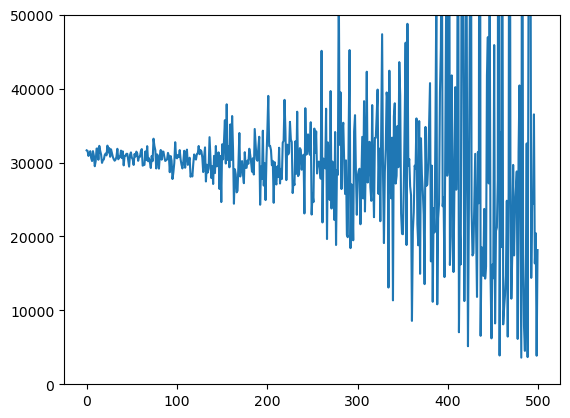

In [72]:
plt.plot(losses)
plt.ylim([0,0.5e5])

In [11]:
0.5*(0.99**500)

0.0032852415212073017

(-1.0, 1.0)

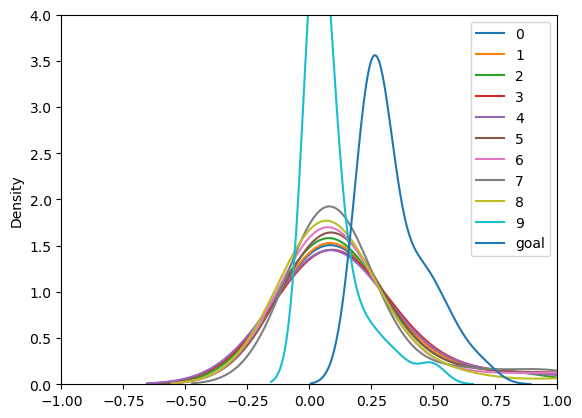

In [73]:
i = 0
for values in posteriorValues[::50]:
    sns.kdeplot(values.detach().numpy(), label=i)
    i += 1
sns.kdeplot(goal,label="goal")
plt.legend()
plt.ylim([0,4])
plt.xlim([-1,1])

In [77]:

def solveComsolTest(E=1, rho=1, eta=1):#, freq=10):
    # Update parameters
    modelComsolFullRange.parameter('youngs', str(E)+' [Pa]')
    modelComsolFullRange.parameter('density', str(rho)+' [kg/m^3]')
    modelComsolFullRange.parameter('eta', str(eta))

    # Solving comsol FEM
    # print(modelComsolFullRange.parameters())
    modelComsolFullRange.solve("Study 2")
    comsolResults = abs(modelComsolFullRange.evaluate("comp1.point1"))

    return comsolResults

E_est = pyro.param("E_mean_guide").item()
eta_est = pyro.param("eta_mean_guide").item()
rho_est = pyro.param("rho_mean_guide").item()
E_std = pyro.param("E_std_guide").item()
eta_std = pyro.param("eta_std_guide").item()
rho_std = pyro.param("rho_std_guide").item()       
print(E_est)  
print(E_std)
rho, eta, E = zzznormalization(rho_est, eta_est, E_est)
y_est = solveComsol(E, rho, eta)
y_total = solveComsolTest(E.detach().numpy(), rho.detach().numpy(), eta.detach().numpy())
y_init = solveComsolTest(9.7e10, 8000.0, 0.00505)

        

        

-0.04859190434217453
0.4285433292388916


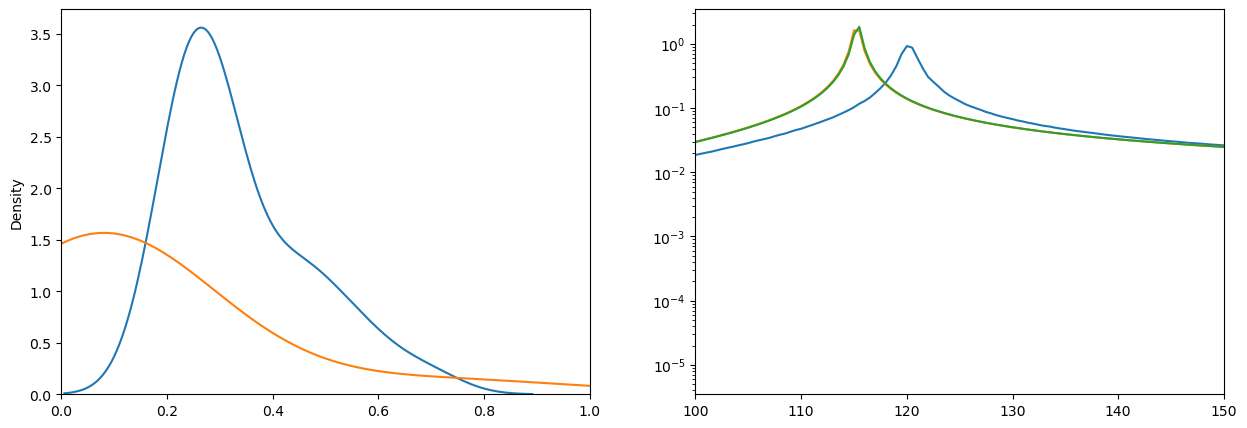

In [78]:
fig, axes = plt.subplots(figsize=(15,5), ncols=2, nrows=1)
sns.kdeplot(goal, ax=axes[0], label="True posterior")
sns.kdeplot(y_est, ax=axes[0], label="estimated posterior")
axes[0].set_xlim([0,1])
freq = experiment["freq"].values
axes[1].plot(freq, mobility)
freq = np.linspace(50, 300, 501)
axes[1].plot(freq, y_total)
axes[1].plot(freq, y_init)
axes[1].set_xlim([100, 150])
axes[1].set_yscale("log")

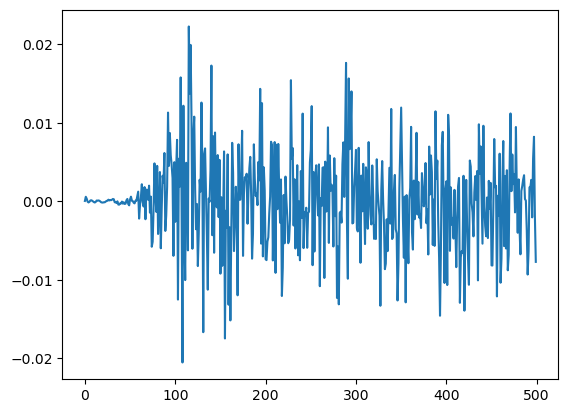

In [54]:
E_val = np.zeros(len(E_values))
eta_val = np.zeros(len(eta_values))
for i in range(len(E_values)):
    E_val[i] = E_values[i].detach().numpy()
    eta_val[i] = eta_values[i].detach().numpy()
plt.plot(eta_val)